# ReAct Agent Architecture

## Aim

This is the intuition behind **ReAct**, a general agent architecture.

1. **Act** – let the model call specific tools  
2. **Observe** – pass the tool output back to the model  
3. **Reason** – let the model reason about the tool output to decide what to do next  
   (e.g. call another tool or just respond directly)

In [ ]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [ ]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [ ]:
arxiv.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [ ]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [ ]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [ ]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGHAIN_PROJECT"]="ReAct-agent"

In [ ]:
### Custom Functions
def multiply(a: int, b: int) -> int:
    """Multiply a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a : int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int,
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> int:
    """Divide a and b.

    Args:
        a:first int,
        b:second int
    """
    return a / b

tools=[arxiv,wiki,add,multiply,divide]

In [ ]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\user\AppData\Local\Temp\ipykernel_2304\3584238.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [ ]:
tavily.invoke("Provide recent AI news for February 12th, 2026")

[{'title': 'Stock market news for Feb.12, 2026 - CNBC',
  'url': 'https://www.cnbc.com/2026/02/11/stock-market-today-live-updates.html',
  'content': 'The move lower in Apple comes after Bloomberg News reported on Wednesday that the company\'s upgrade to the Siri virtual assistant experienced issues during testing, delaying the intended updates over several months. Investors are eagerly awaiting Apple\'s major Siri upgrade along with new artificial intelligence features.\n\nAdding to Apple\'s woes is fresh scrutiny from the Trump administration about possible bias in the company\'s Apple News platform. FTC Chair Andrew Ferguson wrote in a letter posted to X on Wednesday that "there have been reports that Apple News has systematically promoted news articles from left-wing news outlets and suppressed news articles from more conservative publications."\n\nShares of Apple are down nearly 4% year to date.\n\n— Pia Singh [...] Shares of several trucking and logistics companies declined Thurs

In [ ]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily,add,divide,multiply]

In [ ]:
### Initialize my LLM model

from langchain_groq import ChatGroq

llm=ChatGroq(model="openai/gpt-oss-120b")

llm_with_tools=llm.bind_tools(tools)

In [ ]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks "What is the recent AI News". Likely they want a summary of recent AI news. Need up-to-date info. We have access to search via tavily_search_results_json. Use it with query "recent AI news 2024" or "AI news February 2024". Let\'s search.', 'tool_calls': [{'id': 'fc_e1be50a7-8685-4087-95c2-1f6ddfd688a1', 'function': {'arguments': '{"query":"latest AI news February 2024"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 378, 'total_tokens': 480, 'completion_time': 0.211669655, 'completion_tokens_details': {'reasoning_tokens': 65}, 'prompt_time': 0.014777206, 'prompt_tokens_details': None, 'queue_time': 0.017781114, 'total_time': 0.226446861}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_178e424650', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, 

In [ ]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'latest AI news 2024 February'},
  'id': 'fc_9db5e433-3d6b-4e17-b234-603b5a60d295',
  'type': 'tool_call'}]

In [ ]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

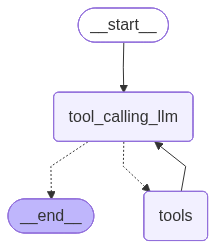

In [ ]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for February 12th 2026,add 5 plus 5 and then multiply by 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for February 12th 2026,add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_87fc4f2e-b8f2-4813-8366-746986e44862)
 Call ID: fc_87fc4f2e-b8f2-4813-8366-746986e44862
  Args:
    query: AI news February 12 2026
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "A Day In The Life Of AI Feb 12, 2026 - Forbes", "url": "https://www.forbes.com/sites/johnwerner/2026/02/13/a-day-in-the-life-of-ai-feb-12-2026/", "content": "History rhymes. The Macintosh was first shown privately at a shareholder meeting, where many couldn’t get in — so Steve Jobs publicly unveiled it at the John Hancock Theater in downtown Boston. Moments like that mark transitions.\n\nThis feels like one of them. [...] The coalit

In [ ]:
messages=graph.invoke({"messages":HumanMessage(content="Search in wikipedia what is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Search in wikipedia what is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (fc_a60ebc6d-cea2-45bc-8958-ede0b9e65a92)
 Call ID: fc_a60ebc6d-cea2-45bc-8958-ede0b9e65a92
  Args:
    query: Machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
================================== Ai Mes

## Agent Memory

### Aim 

Lets introduce Agent With Memory

In [ ]:
messages=graph.invoke({"messages":HumanMessage(content="What is 5 plus 8")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 plus 8
================================== Ai Message ==================================

5 + 8 = 13.


In [ ]:
messages=[HumanMessage(content="Divide that by 5")]
messages=graph.invoke({"messages":messages})
for m in messages['messages']:
    m.pretty_print()

#### MemorySaver

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the **MemorySaver**, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!


In [ ]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")

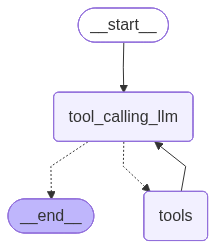

In [26]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

# View
display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [29]:
## Specify the thread

config={"configurable":{"thread_id":"1"}}

# Specify an input
messages = [HumanMessage(content="Add 12 and 13.")]
messages = graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

then multiply than number by 2
================================== Ai Message ==================================

Sure! Could you let me know which number you’d like to multiply by 2? Once I have the value, I’ll calculate the result for you.
================================ Human Message =================================

add than number to 25
================================== Ai Message ==================================

I’m happy to help with the calculation, but I need to know the original number you’d like to work with. Could you please tell me the value you want to multiply by 2 and then add to 25?
================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================

12 + 13 = **25**.


In [30]:
messages = [HumanMessage(content="add than number to 25")]
messages = graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

then multiply than number by 2
================================== Ai Message ==================================

Sure! Could you let me know which number you’d like to multiply by 2? Once I have the value, I’ll calculate the result for you.
================================ Human Message =================================

add than number to 25
================================== Ai Message ==================================

I’m happy to help with the calculation, but I need to know the original number you’d like to work with. Could you please tell me the value you want to multiply by 2 and then add to 25?
================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================

12 + 13 = **25**.
================================ Human Message =================================

add than number to 25
=====

In [31]:
messages = [HumanMessage(content="then multiply than number by 2")]
messages = graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

then multiply than number by 2
================================== Ai Message ==================================

Sure! Could you let me know which number you’d like to multiply by 2? Once I have the value, I’ll calculate the result for you.
================================ Human Message =================================

add than number to 25
================================== Ai Message ==================================

I’m happy to help with the calculation, but I need to know the original number you’d like to work with. Could you please tell me the value you want to multiply by 2 and then add to 25?
================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================

12 + 13 = **25**.
================================ Human Message =================================

add than number to 25
=====